# Model Interpretability

## Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, accuracy_score, classification_report, confusion_matrix
import shap
import xgboost
from xgboost import XGBClassifier, plot_importance
import warnings

In [2]:
shap.initjs()

In [3]:
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading Data

In [4]:
data = pd.read_csv('../data/winequality-red.csv', sep=';')

In [5]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [6]:
data['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [7]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
target = 'quality'
features = data.columns.tolist()

In [9]:
features.remove(target)

## Basic Plots

### Distribution Plot

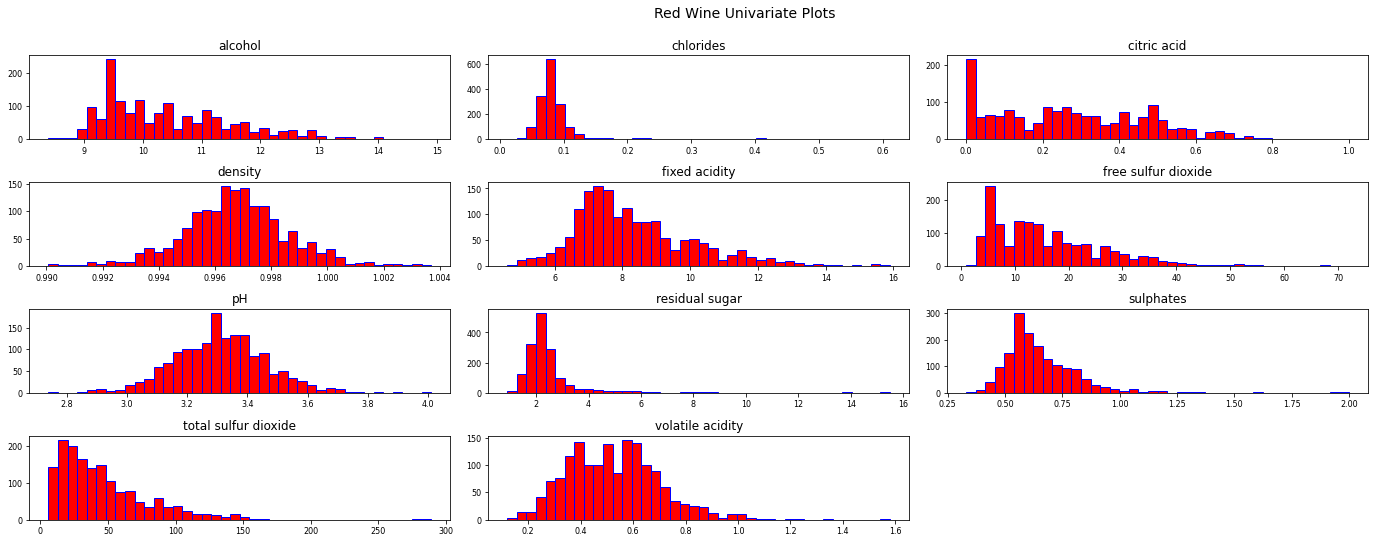

In [10]:
data[features].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')  
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Red Wine Univariate Plots', x=0.65, y=1.25, fontsize=14);  

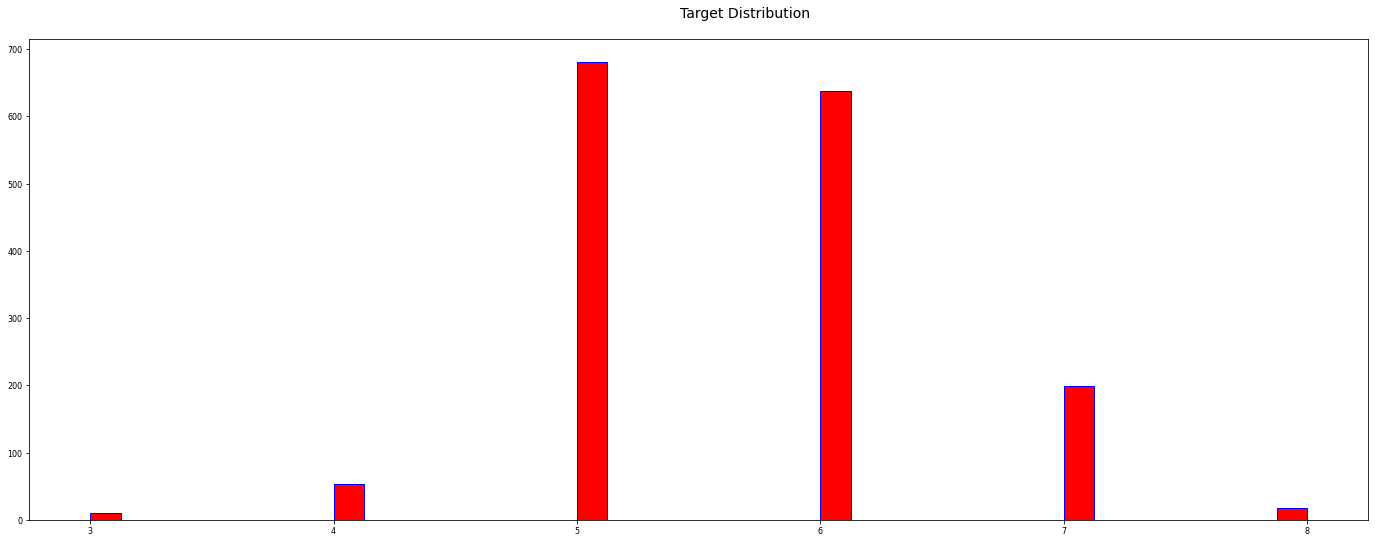

In [11]:
data[target].hist(bins=40, edgecolor='b', linewidth=1.0,
                          xlabelsize=8, ylabelsize=8, grid=False, 
                          figsize=(16,6), color='red')  
plt.tight_layout(rect=(0, 0, 1.2, 1.2))   
plt.suptitle('Target Distribution', x=0.65, y=1.25, fontsize=14);  

### Correlation Plot

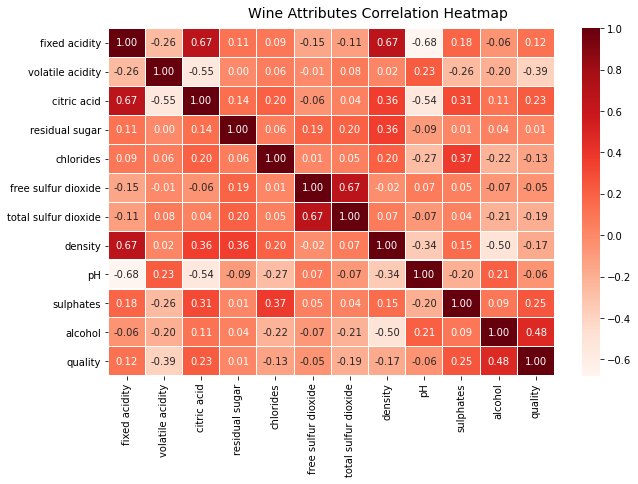

In [12]:
f, ax = plt.subplots(figsize=(10, 6))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="Reds",fmt='.2f',
            linewidths=.05)
f.subplots_adjust(top=0.93)
t = f.suptitle('Wine Attributes Correlation Heatmap', fontsize=14)

### Bivariate Plot

Bivariate data deals with two variables that can change and are compared to find relationships. 

Relplot in seaborn shows relationship between two variables

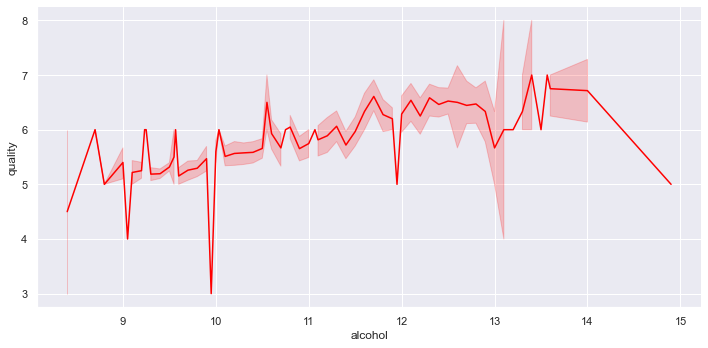

In [13]:
sns.set()
sns.relplot(data=data, x='alcohol', y='quality', kind='line', height=5, aspect=2, color='red')

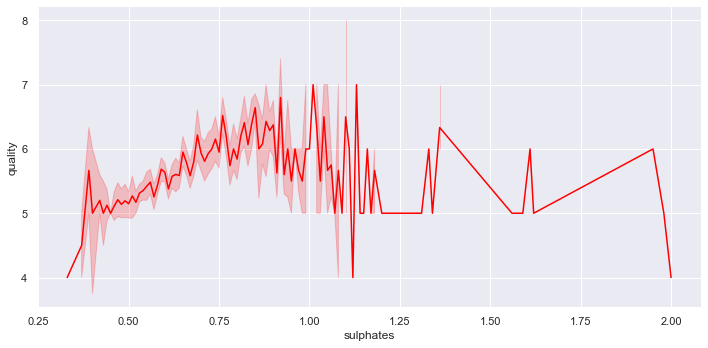

In [14]:
sns.set()
sns.relplot(data=data, x='sulphates', y='quality', kind='line', height=5, aspect=2, color='red')

## Train-test data

In [15]:
y = data.pop('quality')

# mapping the target to a binary class at quality = 5
y = y.apply(lambda x: 0 if x <= 5 else 1)

y.sum() / len(y)

0.5347091932457786

In [16]:
# building train/test datasets on a 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=33)
X_train.shape, X_test.shape

((1119, 11), (480, 11))

## Modelling

In [17]:
xgb = XGBClassifier(objective='binary:logistic')

In [18]:
_ = xgb.fit(X_train, y_train)

## Evaluation

In [19]:
y_pred = xgb.predict(X_test)

In [20]:
def evaluation_scores(test, prediction, target_names=None):
    print('Accuracy:', np.round(accuracy_score(test, prediction), 4)) 
    print('-'*60)
    print('classification report:\n\n', classification_report(y_true=test, y_pred=prediction, target_names=target_names)) 
    
    classes = [0, 1]
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = confusion_matrix(y_true=test, y_pred=prediction, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes], codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], codes=level_labels))
    
    print('-'*60)
    print('Confusion matrix:\n')
    print(cm_frame) 

In [21]:
evaluation_scores(y_test, y_pred, target_names=['Low Quality', 'Hight Quality'])

Accuracy: 0.775
------------------------------------------------------------
classification report:

                precision    recall  f1-score   support

  Low Quality       0.74      0.78      0.76       221
Hight Quality       0.80      0.77      0.79       259

     accuracy                           0.78       480
    macro avg       0.77      0.78      0.77       480
 weighted avg       0.78      0.78      0.78       480

------------------------------------------------------------
Confusion matrix:

          Predicted:     
                   0    1
Actual: 0        172   49
        1         59  200


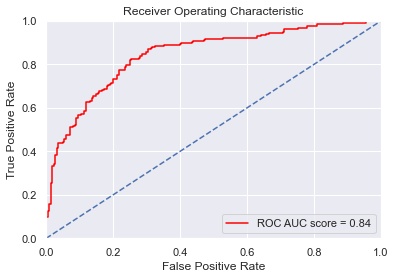

In [22]:
# calculate the FPR and TPR for all thresholds of the classification
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Default Model Interpretation Methods

## XGBOOST
Native global feature importance calculations that come with XGBoostare are based on the following parameters :

* Feature Weights: based on the number of times a feature appears in a tree across the ensemble of trees
* Coverage: the average coverage (number of samples affected) of splits which use the feature
* Gain: the average gain of splits which use the feature

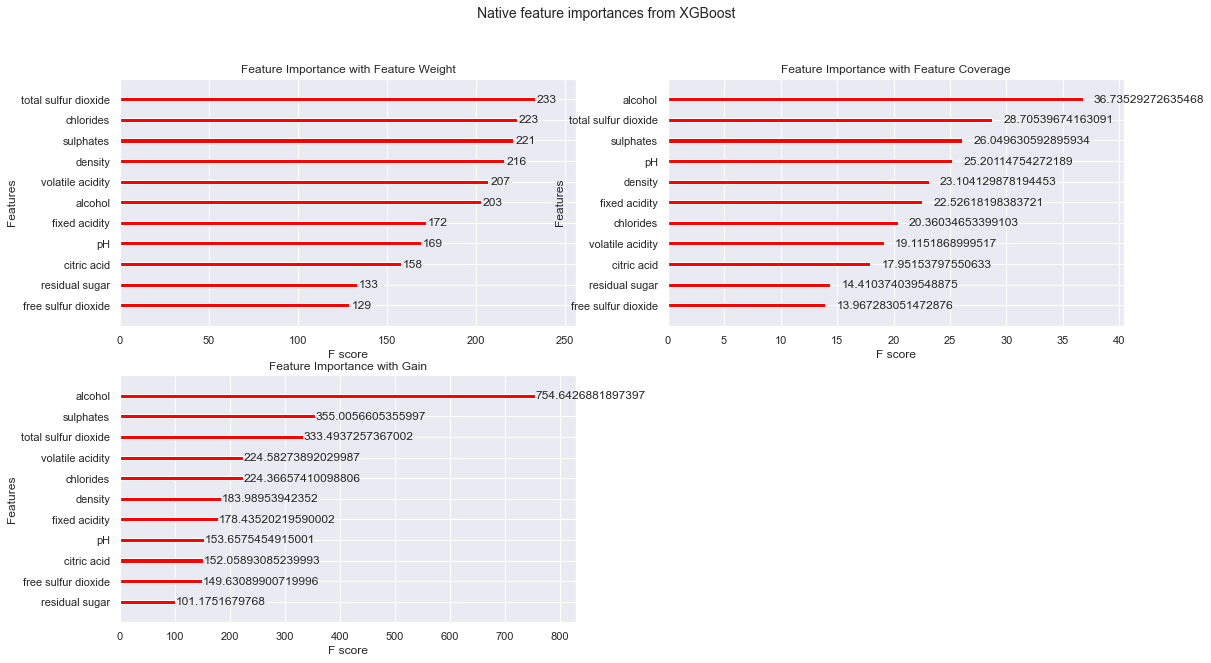

In [23]:
fig = plt.figure(figsize=(18, 10))
fig.suptitle('Native feature importances from XGBoost', fontsize=14)

ax1 = fig.add_subplot(2, 2, 1)
plot_importance(xgb, importance_type='weight', title='Feature Importance with Feature Weight', color='red', ax=ax1)

ax2 = fig.add_subplot(2, 2, 2)
plot_importance(xgb, importance_type='cover', title='Feature Importance with Feature Coverage', color='red', ax=ax2)

ax3 = fig.add_subplot(2, 2, 3)
plot_importance(xgb, importance_type='total_gain', title='Feature Importance with Gain', color='red', ax=ax3)

**The ordering of `features` changes with criterion. We need a more `consistent` way of doing that**

# Model Agnostic Methods

## Partial Dependence Plots(PDP)

Partial Dependence Plots show the marginal effect one or two features have on the predicted outcome, holding other features in the model constant. They show **HOW** a feature affects the predictions

PDP works only when the interaction between the features is weak

Steps -
1. Select feature. 
2. Define grid. 
3. Per grid value: 
    * Replace feature with grid value 
    * Average predictions. 
4. Draw curve.

PDPs follow marginal distribution, as we are interested only in the variation of target variable based on the variance of a single feature, keeping other features constant & assuming that the features are independent. 

In [24]:
# !pip install pdpbox

In [25]:
from pdpbox import get_dataset, pdp, info_plots

In [26]:
def plot_pdp(model, df, feature, cluster_flag=False, nb_clusters=None, lines_flag=False):
    
    # Create the data that we will plot
    pdp_goals = pdp.pdp_isolate(model=model, dataset=df, model_features=df.columns.tolist(), feature=feature)

    # plot it
    pdp.pdp_plot(pdp_goals, feature, cluster=cluster_flag, n_cluster_centers=nb_clusters, plot_lines=lines_flag)
    plt.show()

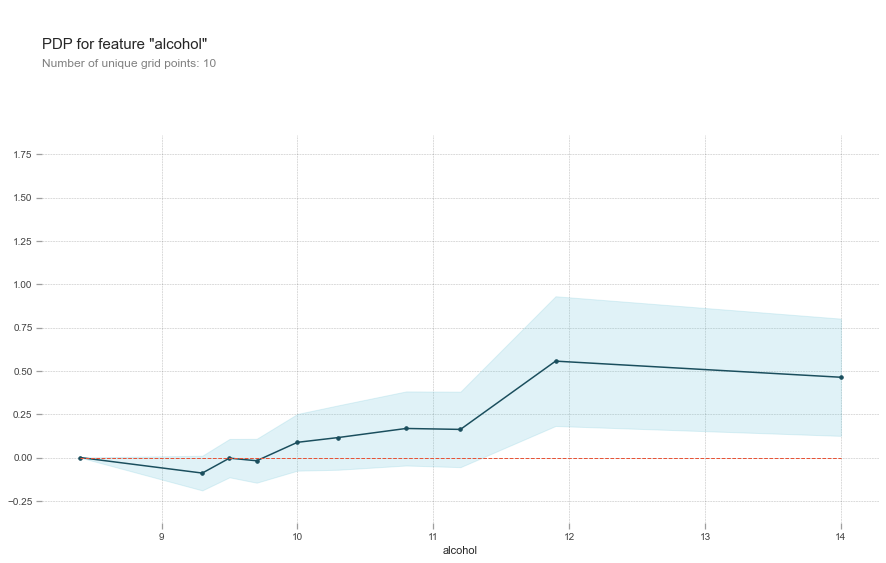

In [27]:
plot_pdp(xgb, X_train, 'alcohol')

**Alcohol has a positive influence on quality between 9.8 & 11.8. After that the influence decreases steadily & before 9.8, it had negative to no influence**

## Individual Conditional Expectation (ICE) Plots

Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance’s prediction changes when a feature changes.

An ICE plot visualizes the dependence of the prediction on a feature for each instance separately, resulting in one line per instance, compared to one line overall in partial dependence plots. 

A PDP is the average of the lines of an ICE plot. 

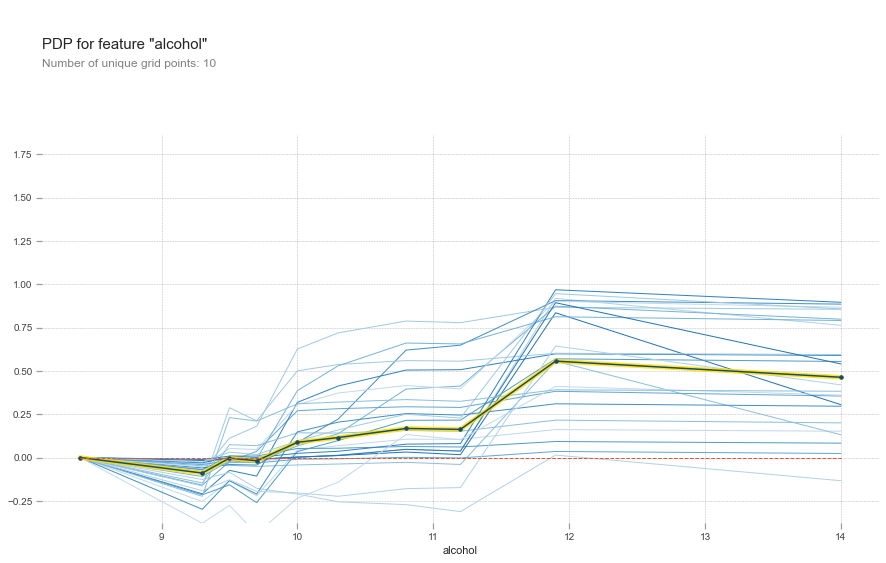

In [28]:
plot_pdp(xgb, X_train, 'alcohol', cluster_flag=True, nb_clusters=24, lines_flag=True)

## Shapley Values

The Shapley value, coined by Shapley, is a method for assigning payouts to players depending on their contribution to the total payout. Players cooperate in a coalition and receive a certain profit from this cooperation.

The “game” is the prediction task for a single instance of the dataset. The “gain” is the actual prediction for this instance minus the average prediction for all instances (hence works with probabilities or regression). The “players” are the feature values of the instance that collaborate to receive the gain

>The Shapley value is the average marginal contribution of a feature value across all possible coalitions.

The interpretation of the Shapley value for feature value `j` is: The value of the j-th feature contributed  `ϕj` to the prediction of this particular instance compared to the average prediction for the dataset.

The Shapley value works for both classification (only when dealing with probabilities) and regression.

### Properties
**Effeciency**<br>
The feature contributions must add up to the difference of prediction for x and the average.

**Symmetry**<br>
The contributions of two feature values `j` and `k` should be the same if they contribute equally to all possible coalitions.

**Dummy**<br>
A feature `j` that **does not change the predicted value** – regardless of which coalition of feature values it is added to – **should have a Shapley value of 0**

**Additivity**<br>
Suppose you trained a random forest, which means that the prediction is an average of many decision trees. The Additivity property guarantees that for a feature value, you can calculate the Shapley value for each tree individually, average them, and get the Shapley value for the feature value for the random forest.


### Using Bare XGBoost 

The expected value equals to the average of predicted outputs of the training dataset.

In [29]:
params = xgb.get_xgb_params()

In [30]:
dtrain = xgboost.DMatrix(X_train, label=y_train, feature_names=X_train.columns.tolist())
dtest = xgboost.DMatrix(X_test, label=y_test, feature_names=X_test.columns.tolist())
bst = xgboost.train(params=params, dtrain=dtrain, num_boost_round=100)

`pred_contribs (bool)` – When this is True the output will be a matrix of size *(nsample, nfeats + 1)* with each record indicating the feature contributions (SHAP values) for
that prediction. The sum of all feature contributions is equal to the raw untransformed
margin value of the prediction.

In [31]:
expected_value = bst.predict(dtrain, pred_contribs=True, validate_features=True)

In [32]:
shap_values_self = bst.predict(dtest, pred_contribs=True, validate_features=True)

In [33]:
expected_value[0, -1]

0.15005846

In [34]:
shap.force_plot(expected_value[0,-1], shap_values_self[0,:11], X_test.iloc[0,:])

In [35]:
# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [36]:
sum(expected_value[0,:13])

4.826826674863696

In [37]:
dtrain = xgboost.DMatrix(X, label=y, feature_names=X.columns.tolist())
bst = xgboost.train(params={"learning_rate": 0.01}, dtrain=dtrain, num_boost_round=100)

expected_value = bst.predict(dtrain, pred_contribs=True)

shap.force_plot(expected_value[0,-1], expected_value[0,:13], X.iloc[0,:])

### Using Shap Library

In [38]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

In [39]:
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

In [40]:
explainer.expected_value

0.15005846

**Notice that the expected value calculated using shap library matches that with original mechanism**

Tree SHAP (the algorithm inside TreeExplainer) explains the output of trees, and the output of the trees in XGBoost are log-odds no matter if you use `binary:logistic`

In [41]:
print(f"Probabilities: {y_pred_proba[0]}")
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0])

Probabilities: [0.9759624  0.02403763]


**Also notice that the feature contributions match with the one calculated in the previous section**

In [42]:
print(f"Probabilities: {y_pred_proba[2]}")
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2])

Probabilities: [0.97053474 0.02946524]


In [43]:
print(f"Probabilities: {y_pred_proba[8]}")
shap.force_plot(explainer.expected_value, shap_values[8,:], X_test.iloc[8])

Probabilities: [0.25072205 0.74927795]


In [44]:
print(f"Probabilities: {y_pred_proba[16]}")
shap.force_plot(explainer.expected_value, shap_values[16,:], X_test.iloc[16])

Probabilities: [0.2913726 0.7086274]


### Important Points

1. Samples with similar probability values, have `predicted_value` quite close to each other. For example, the above pairs (`X[0]` & `X[2]`) have similar probs for class 0, they also have final values (-3.49, -3.70) close to each other. Same thing goes for another pair of `X[8]` & `X[16]`. 
2. Sum of shapley values of all features for a given sample, does sum up to `base_value - predicted_value`.

In [45]:
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1])

In [46]:
temp = pd.DataFrame.from_dict({"Cols": X_test.columns, "Shapley Values": shap_values[1,:]})
temp = temp.sort_values(by='Shapley Values', ascending=False)
temp

,Cols,Shapley Values
10,alcohol,5.666499
4,chlorides,0.724451
7,density,0.509802
5,free sulfur dioxide,0.476708
6,total sulfur dioxide,0.435118
9,sulphates,0.430178
3,residual sugar,0.364536
2,citric acid,-0.142927
1,volatile acidity,-0.198918
0,fixed acidity,-0.850684


## Accumulated Local Effects (ALE) Plots

### Problem

If features of a machine learning model are correlated, the partial dependence plot cannot be trusted. The computation of a partial dependence plot for a feature that is **strongly correlated with other features involves averaging predictions of artificial data instances that are unlikely in reality**.

Example - Consider the prediction for house prices given *Living Area & Number of Rooms*. Now, if we fix *Living Area to say 30m2* & vary *Number of Rooms* from 1 to 10, then it would lead to unreal/unusual houses.  The partial dependence plot would include these unrealistic houses in the feature effect estimation and pretends that everything is fine.

A simple solution is to use `conditional distribution` i.e. keeping *Living Area=30m2*, we take *Number of Rooms* from the distribution `P(Number of Rooms | Living Area=30)` and then average only over these points. However, we estimate the combined effect of living area and of number of rooms, because of their correlation. 

### Solution

ALE plots based on `conditional distribution` takes differences in predictions instead of average.

For the effect of `Living Area` at *30m2*, the ALE method uses all houses with about *30m2*, gets the model predictions pretending these houses were *31m2* minus the prediction pretending they were *29m2*. This gives us the pure effect of the living area and is not mixing the effect with the effects of correlated features. 

## Permutation Feature Importance/Model Reliance

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature’s values, which breaks the relationship between the feature and the true outcome.

A feature is important if shuffling it's value increases the model error. On the other hand, a feature is unimportant if shuffling it's value leaves the model error unchanged.

1. Estimate the original model error E<sup>orig</sup> = L(y, f(X)) 
2. For each feature j = 1,…,p do:
    * Generate feature matrix X<sup>perm</sup> by permuting feature j in the data X. This breaks the association between feature j and true outcome y.
    * Estimate error E<sup>perm</sup> = L(Y, f(X<sup>perm</sup>)) based on the predictions of the permuted data.
    * Calculate permutation feature importance FI<sub>j</sub>= E<sup>perm</sup>/E<sup>orig</sup> 
3. Sort features by descending FI.


**The skater feature importance implementation is based on an information theoretic criteria, measuring the entropy in the change of predictions, given a perturbation of a given feature.**

In [47]:
# !echo "Someone@123" | sudo -S conda install --yes -c conda-forge skater

In [48]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation
model = InMemoryModel(xgb.predict_proba, examples = X_train)
interpreter = Interpretation()
interpreter.load_data(X_train)
interpreter.feature_importance.feature_importance(model, ascending=False)

ModuleNotFoundError: No module named 'skater'

In [ ]:
interpreter.feature_importance.plot_feature_importance(predict_fn=model, ascending=False, progressbar=True)

### Advantages
* Simple to interpret
* Does not require retraining the model

### Disadvantage
* Require true labels to evaluate
* The permutation feature importance depends on shuffling the feature, which adds randomness to the measurement. Repeating the permutation and averaging the importance measures over repetitions stabilizes the result.
* If the features are correlated, random shuffling the features could generate unnatural data points. Example - Height-2M & Weight-60KG. These data points could affect the actual feature importance.
* Adding a correlated feature can decrease the importance of the associated feature by splitting the importance between both features.

## Global Surrogate

A global surrogate model is an interpretable model that is trained to approximate the predictions of a black box model. We can draw conclusions about the black box model by interpreting the surrogate model. 

1. Select a dataset X. This can be the same dataset that was used for training the black box model or a new dataset from the same distribution. You could even select a subset of the data or a grid of points, depending on your application.
2. For the selected dataset X, get the predictions of the black box model.
3. Select an interpretable model type (linear model, decision tree, …).
4. Train the interpretable model on the dataset X and its predictions.
5. Measure how well the surrogate model replicates the predictions of the black box model.
6. Interpret the surrogate model.

One way to measure how well the surrogate model replicates black box model is R-squared. If the value is close to 1, then the surrogate model approximates the behavior of black box very well. If the score is close to 0, then the surrogate model fails to explain the black box model.

Points:
1. We make conclusions about the blackbox model & not the data
2. It is not clear what the best cut-off for R-squared is